In [219]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from kan import KAN as PyKAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from tqdm import tqdm

plt.rcParams.update({'font.size': 18})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Fault Detection
In this notebook we'll train a `PyKAN` network to distinguish between *faulty* and *not-faulty* operating regimes.

## Load dataset

In [2]:
features = ['trq_measured', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng', 'trq_margin']
target = 'faulty'

In [154]:
df_x = pd.read_csv('../dataset/X_train.csv')
df_y = pd.read_csv('../dataset/y_train.csv')
df_x_normalized = (df_x - df_x.mean()) / df_x.std()
df_x_normalized['id'] = df_x['id']
df = df_x_normalized.merge(df_y, on='id').drop(columns='id')

X = df[features].values
y = df[target].values

In [155]:
# 10% Train + 45% Validation + 45% Test
df_train_x, df_valid_test_x, df_train_y, df_valid_test_y = train_test_split(X, y, test_size=0.9, stratify=y,
                                                                            random_state=42)
df_valid_x, df_test_x, df_valid_y, df_test_y = train_test_split(df_valid_test_x, df_valid_test_y, test_size=0.5,
                                                                stratify=df_valid_test_y, random_state=42)
len(df_train_x), len(df_valid_x), len(df_test_x)

(74262, 334181, 334182)

In [156]:
train_x = torch.tensor(df_train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(df_train_y, dtype=torch.long).to(device)

valid_x = torch.tensor(df_valid_x, dtype=torch.float32).to(device)
valid_y = torch.tensor(df_valid_y, dtype=torch.long).to(device)

test_x = torch.tensor(df_test_x, dtype=torch.float32).to(device)
test_y = torch.tensor(df_test_y, dtype=torch.long).to(device)

## Define the train() and test() functions

In [134]:
def score(confidence: torch.Tensor, true_labels: torch.Tensor) -> torch.Tensor:
    pred_labels: torch.Tensor = torch.where(confidence > 0.5, 1, 0)
    confidence = torch.sigmoid(confidence)

    # Mask for valid confidences (between 0 and 1)
    valid_confidence_mask = (confidence >= 0) & (confidence <= 1)
    # Mask for valid labels (0 or 1)
    valid_label_mask = (pred_labels == 0) | (pred_labels == 1)
    # Combined mask for valid inputs
    valid_mask = valid_confidence_mask & valid_label_mask

    # Invert confidence for incorrect predictions
    adjusted_confidence = torch.where(pred_labels == 0, 1 - confidence * 2, (confidence - 0.5) * 2)
    adjusted_confidence = torch.where(pred_labels == true_labels, adjusted_confidence, -adjusted_confidence)

    # Calculate scores for "healthy" (true label == 0)
    healthy_scores = adjusted_confidence.clone()

    # Calculate scores for "faulty" (true label == 1)
    faulty_scores = torch.where(
        adjusted_confidence >= 0,
        adjusted_confidence,
        4 * adjusted_confidence ** 11 + adjusted_confidence
    )

    # Assign scores based on true labels
    scores = torch.where(
        true_labels == 0,
        healthy_scores,
        faulty_scores
    )

    # Only keep scores for valid entries
    scores = torch.where(valid_mask, scores, -100.0)

    return scores


assert (torch.dist(
    score(torch.tensor([9999, 1, -999]), torch.tensor([1, 1, 1])),
    torch.tensor([1.0000, 0.4621, -5.0000])
) < 0.0001)

In [186]:
def train(model, optimizer, epochs, batch_size=8192, false_neg_penalty=2.0):
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([false_neg_penalty]).to(device))
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_validation_losses = []

        # Training
        model.train()
        with tqdm(range(train_x.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = train_x[i * batch_size:(i + 1) * batch_size]
                y = train_y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                confidence = model(x).squeeze()
                loss = criterion(confidence, y.float())
                loss.backward()
                epoch_train_losses.append(loss.item())
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        scheduler.step()

        # Validation
        model.eval()
        for i in range(valid_x.size(0) // batch_size):
            x = valid_x[i * batch_size:(i + 1) * batch_size]
            y = valid_y[i * batch_size:(i + 1) * batch_size]
            confidence = model(x).squeeze()
            loss = criterion(confidence, y.float())
            loss.backward()
            epoch_validation_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))
        validation_losses.append(np.mean(epoch_validation_losses))

    # Plot losses
    plt.figure(figsize=(24, 8))
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()
    plt.show()

In [227]:
def test(model, batch_size=8192):
    model.eval()
    scores = []
    y_pred = []
    for i in range(test_x.size(0) // batch_size):
        x = test_x[i * batch_size:(i + 1) * batch_size]
        y = test_y[i * batch_size:(i + 1) * batch_size]
        confidence = model(x).squeeze()
        scores.extend(score(confidence, y).tolist())
        y_pred.extend(torch.where(torch.sigmoid(confidence) > 0.5, 1, 0).tolist())
    labels = test_y.cpu()[:len(y_pred)]
    acc = accuracy_score(labels, y_pred)
    prec = precision_score(labels, y_pred)
    rec = recall_score(labels, y_pred)
    f1 = f1_score(labels, y_pred)
    print(f'Avg Test Score: {sum(scores) / len(scores):.3f}')
    print('-------------------------')
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    cm = confusion_matrix(labels, y_pred)
    cm_percentage = cm.astype('float') / cm.sum() * 100
    labels = np.array([[f'{value:.2f}%' for value in row] for row in cm_percentage])
    plt.figure(figsize=(16, 10))
    sns.heatmap(cm_percentage, annot=labels, fmt='', cmap="viridis", xticklabels=["Nominal (0)", "Faulty (1)"],
                yticklabels=["Nominal (0)", "Faulty (1)"])
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.title("Confusion matrix")
    plt.show()

# With CrossEntropyLoss

In [175]:
class Py_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Py_KAN, self).__init__()
        self.model = PyKAN(width=layers, grid=grid_size, k=3, device=device)

    def forward(self, x):
        return self.model(x)

In [206]:
pyKAN = Py_KAN(layers=[[8, 0], [1, 0], [1, 0]], grid_size=5)

checkpoint directory created: ./model
saving model version 0.0


In [203]:
pyKAN.model = PyKAN.loadckpt('models/multipykan_grid-2.pt')

C:\Users\MrPio\AppData\Local\Programs\Python\Python310\lib\site-packages\kan\MultKAN.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'{path}_state'

100%|██████████| 9/9 [00:00<00:00, 38.85it/s, loss=0.2, lr=0.0282]  


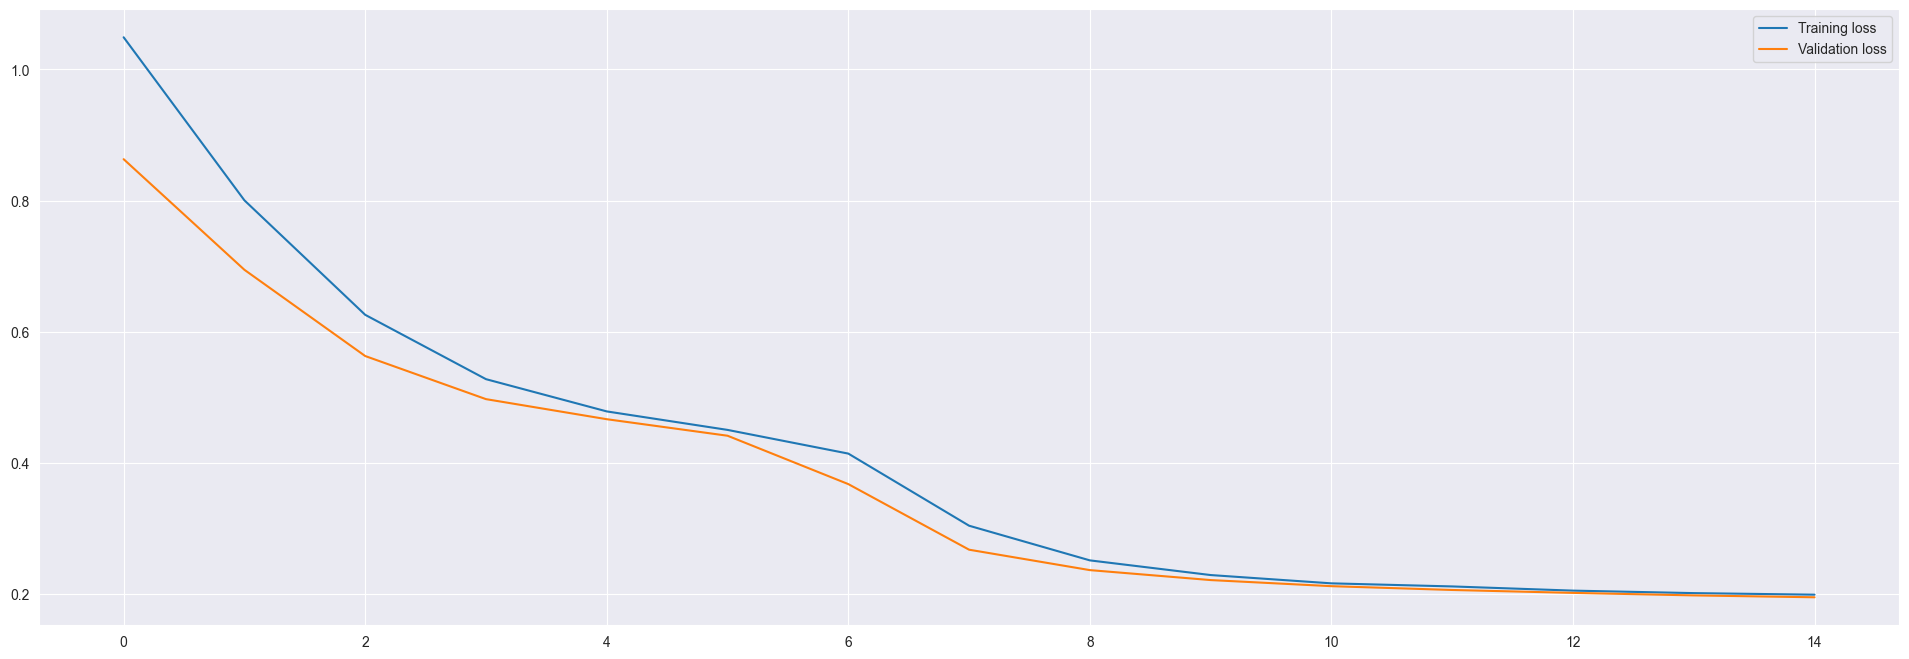

In [207]:
train(pyKAN, optim.Adam(pyKAN.parameters(), lr=0.05), epochs=15, false_neg_penalty=2.0)

Avg Test Score: 0.815
-------------------------
Accuracy:  0.950
Precision: 0.933
Recall:    0.945
F1-score:  0.939


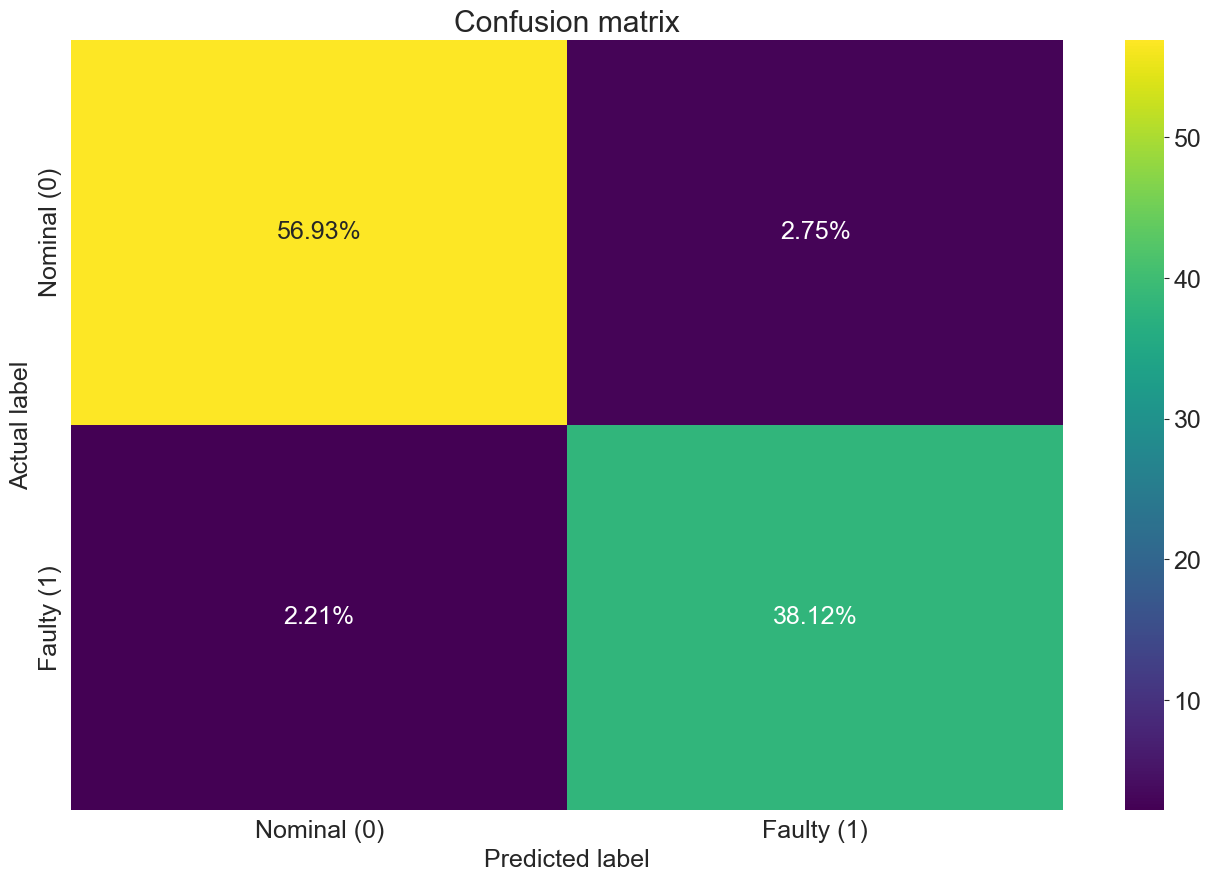

In [229]:
test(pyKAN)

In [210]:
pyKAN.model.saveckpt('models/pykan_simple_grid-5.pt')

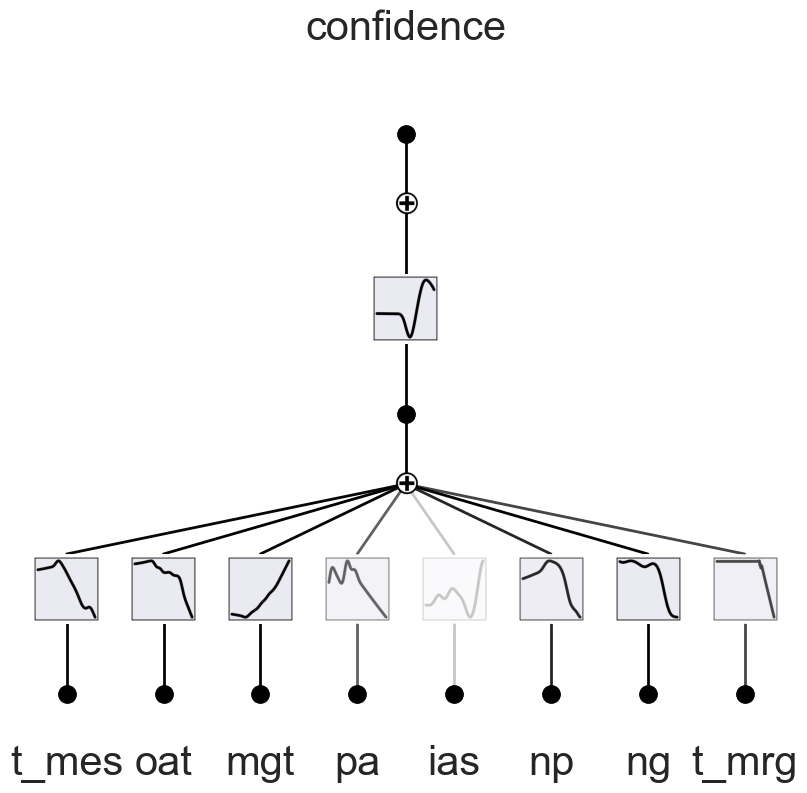

In [228]:
pyKAN.model.plot(scale=1, in_vars=['t_mes', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng', 't_mrg'], out_vars=['confidence'],
                 varscale=0.75)